In [8]:
import torch
import torch.nn as nn
import os
import numpy as np
import pandas as pd
import timm
import matplotlib.pyplot as plt

from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import ViTModel, ViTImageProcessor
from transformers import AutoTokenizer, RobertaModel


## Processing and loading data

In [9]:
# Load train data
train_data = []
train_set_path = 'data/vaq2.0.TrainImages.txt'

with open(train_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        train_data.append(data_sample)

# Load val data
val_data = []
val_set_path = 'data/vaq2.0.DevImages.txt'

with open(val_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        val_data.append(data_sample)

# Load test data
test_data = []
test_set_path = 'data/vaq2.0.TestImages.txt'

with open(test_set_path, "r") as f:
    lines = f.readlines()
    for line in lines:
        temp = line.split('\t')
        qa = temp[1].split('?')

        if len(qa) == 3:
            answer = qa[2].strip()
        else:
            answer = qa[1].strip()

        data_sample = {
            'image_path': temp[0][:-2],
            'question': qa[0] + '?',
            'answer': answer
        }
        test_data.append(data_sample)


### Build dictionary mapping classes

In [10]:
classes = set([sample['answer'] for sample in train_data])

classes_to_idx = {cls_name: idx for idx, cls_name in enumerate(classes)}

idx_to_classes = {idx: cls_name for idx, cls_name in enumerate(classes)}


### pytorch dataset loader

In [11]:
class VQADataset(Dataset):
    def __init__(
        self,
        data,
        classes_to_idx,
        img_feature_extractor,
        text_tokenizer,
        device,
        root_dir='/space/hotel/bachn/VQA/data/val2014-resised'
    ):
        self.data = data
        self.root_dir = root_dir
        self.classes_to_idx = classes_to_idx
        self.img_feature_extractor = img_feature_extractor
        self.text_tokenizer = text_tokenizer
        self.device = device

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.data[index]['image_path'])
        img = Image.open(img_path).convert('RGB')

        if self.img_feature_extractor:
            img = self.img_feature_extractor(images=img, return_tensors="pt")
            img = {k: v.to(self.device).squeeze(0) for k, v in img.items()}

        question = self.data[index]['question']
        if self.text_tokenizer:
            question = self.text_tokenizer(
                question,
                padding="max_length",
                max_length=20,
                truncation=True,
                return_tensors="pt"
            )
            question = {k: v.to(self.device).squeeze(0) for k, v in question.items()}

        label = self.data[index]['answer']
        label = torch.tensor(
            classes_to_idx[label],
            dtype=torch.long
        ).to(self.device)

        sample = {
            'image': img,
            'question': question,
            'label': label
        }

        return sample


### Load data for train,val,test

In [12]:
img_feature_extractor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
text_tokenizer = AutoTokenizer.from_pretrained("roberta-base")
device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_dataset = VQADataset(
    train_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)

val_dataset = VQADataset(
    val_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)

test_dataset = VQADataset(
    test_data,
    classes_to_idx=classes_to_idx,
    img_feature_extractor=img_feature_extractor,
    text_tokenizer=text_tokenizer,
    device=device
)
train_batch_size = 128
test_batch_size = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False
)

## Model

In [13]:
class TextEncoder(nn.Module):
    def __init__(self):
        super(TextEncoder, self).__init__()
        self.model = RobertaModel.from_pretrained("roberta-base")

    def forward(self, inputs):
        outputs = self.model(**inputs)
        return outputs.pooler_output
    
    
class VisualEncoder(nn.Module):
    def __init__(self):
        super(VisualEncoder, self).__init__()
        self.model = ViTModel.from_pretrained("google/vit-base-patch16-224")

    def forward(self, inputs):
        outputs = self.model(**inputs)
        return outputs.pooler_output
    
    
class Classifier(nn.Module):
    def __init__(
        self,
        input_size=768*2,
        hidden_size=512,
        n_layers=1,
        dropout_prob=0.2,
        n_classes=2
    ):
        super(Classifier, self).__init__()
        self.lstm = nn.LSTM(
            input_size,
            hidden_size,
            num_layers=n_layers,
            batch_first=True,
            bidirectional=True
        )
        self.dropout = nn.Dropout(dropout_prob)
        self.fc1 = nn.Linear(hidden_size*2, n_classes)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = self.dropout(x)
        x = self.fc1(x)
        return x
### VQA model
class VQAModel(nn.Module):
    def __init__(
        self,
        visual_encoder,
        text_encoder,
        classifier
    ):
        super(VQAModel, self).__init__()
        self.visual_encoder = visual_encoder
        self.text_encoder = text_encoder
        self.classifier = classifier

    def forward(self, image, answer):
        text_out = self.text_encoder(answer)
        image_out = self.visual_encoder(image)
        x = torch.cat((text_out, image_out), dim=1)
        x = self.classifier(x)
        return x

    def freeze(self, visual=True, textual=True, clas=False):
        if visual:
            for n, p in self.visual_encoder.named_parameters():
                p.requires_grad = False
        if textual:
            for n, p in self.text_encoder.named_parameters():
                p.requires_grad = False
        if clas:
            for n, p in self.classifier.named_parameters():
                p.requires_grad = False


### Model Setup

In [14]:
n_classes = len(classes)
hidden_size = 1024
n_layers = 1
dropout_prob = 0.2

text_encoder = TextEncoder().to(device)
visual_encoder = VisualEncoder().to(device)
classifier = Classifier(
    hidden_size=hidden_size,
    n_layers=n_layers,
    dropout_prob=dropout_prob,
    n_classes=n_classes
).to(device)

model = VQAModel(
    visual_encoder=visual_encoder,
    text_encoder=text_encoder,
    classifier=classifier
).to(device)
model.freeze()


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Evaluate and train function

In [15]:
def evaluate(model, dataloader, criterion):
    model.eval()
    correct = 0
    total = 0
    losses = []
    with torch.no_grad():
        for idx, inputs in enumerate(dataloader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    loss = sum(losses) / len(losses)
    acc = correct / total
    return loss, acc


def fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        batch_train_losses = []

        model.train()
        for idx, inputs in enumerate(train_loader):
            images = inputs['image']
            questions = inputs['question']
            labels = inputs['label']

            optimizer.zero_grad()
            outputs = model(images, questions)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            batch_train_losses.append(loss.item())

        train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader, criterion)
        val_losses.append(val_loss)

        print(f'EPOCH {epoch + 1}:\tTrain loss: {train_loss:.4f}\tVal loss: {val_loss:.4f}\tVal Acc: {val_acc}')

        scheduler.step()

    return train_losses, val_losses



In [16]:
lr = 1e-2
epochs = 50
scheduler_step_size = epochs * 0.6
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr
)
scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=scheduler_step_size,
    gamma=0.1
)


## Traing and evalute

In [14]:
train_losses, val_losses = fit(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    scheduler,
    epochs
)

EPOCH 1:	Train loss: 1.0207	Val loss: 0.7349	Val Acc: 0.4646516393442623
EPOCH 2:	Train loss: 0.7151	Val loss: 0.7509	Val Acc: 0.4641393442622951
EPOCH 3:	Train loss: 0.7164	Val loss: 0.6951	Val Acc: 0.5363729508196722
EPOCH 4:	Train loss: 0.7529	Val loss: 0.7242	Val Acc: 0.46875
EPOCH 5:	Train loss: 0.7367	Val loss: 0.8027	Val Acc: 0.5358606557377049
EPOCH 6:	Train loss: 0.7121	Val loss: 0.7014	Val Acc: 0.5220286885245902
EPOCH 7:	Train loss: 0.7242	Val loss: 0.8009	Val Acc: 0.4651639344262295
EPOCH 8:	Train loss: 0.6992	Val loss: 0.6841	Val Acc: 0.5496926229508197
EPOCH 9:	Train loss: 0.7067	Val loss: 0.6848	Val Acc: 0.5671106557377049
EPOCH 10:	Train loss: 0.7028	Val loss: 0.6977	Val Acc: 0.545594262295082
EPOCH 11:	Train loss: 0.7536	Val loss: 0.7157	Val Acc: 0.5225409836065574
EPOCH 12:	Train loss: 0.7299	Val loss: 0.6919	Val Acc: 0.516905737704918
EPOCH 13:	Train loss: 0.7052	Val loss: 0.6785	Val Acc: 0.5578893442622951
EPOCH 14:	Train loss: 0.7114	Val loss: 0.7778	Val Acc: 0.539

In [16]:
val_loss, val_acc = evaluate(
    model,
    val_loader,
    criterion
)

test_loss, test_acc = evaluate(
    model,
    test_loader,
    criterion
)

print('Evaluation on val / test dataset')
print('Val accuracy: ', val_acc)
print('Test accuracy: ', test_acc)

Evaluation on val / test dataset
Val accuracy:  0.6403688524590164
Test accuracy:  0.625618199802176


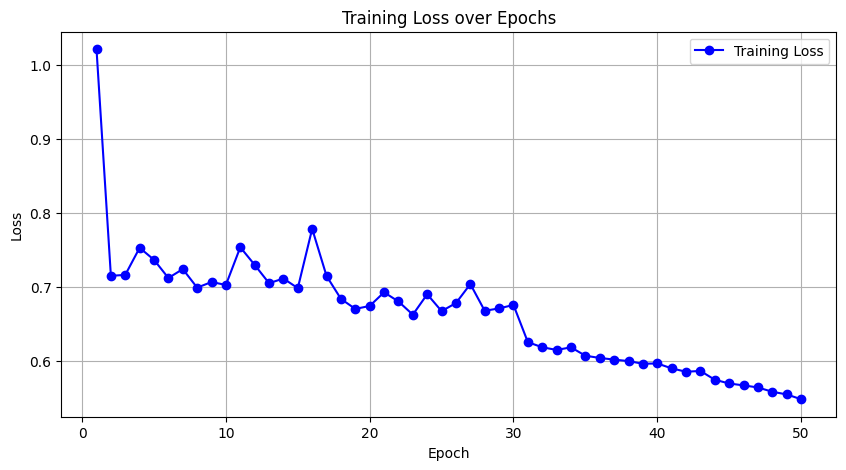

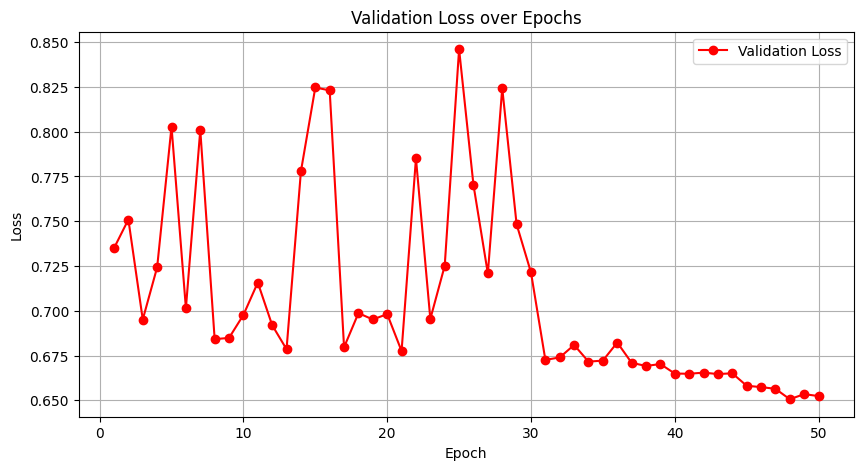

In [17]:
import matplotlib.pyplot as plt

# Assuming you have `train_losses` and `val_losses` lists from your training process
epochs = range(1, len(train_losses) + 1)

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_losses, label='Training Loss', marker='o', linestyle='-', color='b')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot validation loss
plt.figure(figsize=(10, 5))
plt.plot(epochs, val_losses, label='Validation Loss', marker='o', linestyle='-', color='r')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [23]:
val_acc

0.6403688524590164